# Проект e-commerce
### Данные и задания предоставлены Karpov.courses

# Задания

1. Сколько у нас пользователей, которые совершили покупку только один раз? 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

# Описание данных

#### customers — таблица с уникальными идентификаторами пользователей

- customer_id — позаказный идентификатор пользователя

- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

- customer_zip_code_prefix —  почтовый индекс пользователя

- customer_city —  город доставки пользователя

- customer_state —  штат доставки пользователя

#### orders —  таблица заказов

- order_id —  уникальный идентификатор заказа (номер чека)

- customer_id —  позаказный идентификатор пользователя

- order_status —  статус заказа

- order_purchase_timestamp —  время создания заказа

- order_approved_at —  время подтверждения оплаты заказа

- order_delivered_carrier_date —  время передачи заказа в логистическую службу

- order_delivered_customer_date —  время доставки заказа

- order_estimated_delivery_date —  обещанная дата доставки

#### items —  товарные позиции, входящие в заказы

- order_id —  уникальный идентификатор заказа (номер чека)

- order_item_id —  идентификатор товара внутри одного заказа

- product_id —  ид товара (аналог штрихкода)

- seller_id — ид производителя товара

- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- price —  цена за единицу товара

- freight_value —  вес товара

Уникальные статусы заказов в таблице orders:

- created —  создан

- approved —  подтверждён

- invoiced —  выставлен счёт

- processing —  в процессе сборки заказа

- shipped —  отгружен со склада

- delivered —  доставлен пользователю

- unavailable —  недоступен

- canceled —  отменён

### Загрузим данные, сделаем предобработку и определим, что считать покупкой.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.ticker as ticker

import requests
from urllib.parse import urlencode

from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Считаем данные и проведем их предобработку.

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

public_key_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
public_key_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
public_key_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [4]:
def get_frame(base_url, public_key):

    final_url = base_url + urlencode(dict(public_key=public_key))

    response = requests.get(final_url)

    download_url = response.json()['href']

    download_response = requests.get(download_url)

    return pd.read_csv(download_url)

In [5]:
customers = get_frame(base_url, public_key_customers)
orders = get_frame(base_url, public_key_orders)
items = get_frame(base_url, public_key_items)

#### Посмотрим на данные в таблице c клиентами 'Customers'

In [6]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
customers.shape

(99441, 5)

In [8]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [9]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [10]:
customers.duplicated().sum()

0

In [11]:
customers.customer_id.nunique()

99441

In [12]:
customers.customer_unique_id.nunique()

96096

В таблице Customers нет пропущенных значений и отсутствуют дубликаты.

Всего 96096 уникальных пользователя, которые суммарно оформили 99441 заказ.

С каждым новым заказом пользователю присваивается новый позаказный номер 'customer_id'.

#### Посмотрим на данные в таблице заказов 'Orders'

In [13]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [14]:
orders.shape

(99441, 8)

In [15]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Приведем колонки с датой и временем к формату datetime.

In [16]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

In [17]:
orders.duplicated().sum()

0

In [18]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [19]:
orders.order_status.value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [20]:
np.round(orders.order_status.value_counts().loc['delivered'] / orders.shape[0] * 100, 2)

97.02

Всего был оформлен 99441 заказ.

Дубликаты в таблице Orders отсутствуют, однако есть пропущенные значения в колонках:
- 'order_approved_at' (160)
- 'order_delivered_carrier_date' (1783)
- 'order_delivered_customer_date' (2965)

97.02% заказов имеют статус 'delivered' - доставлены пользователю.

#### Посмотрим на данные об отдельных товарах в заказе в таблице 'items'

In [21]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [22]:
items.shape

(112650, 7)

In [23]:
items.duplicated().sum()

0

In [24]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [25]:
items.order_id.value_counts()

order_id
8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
                                    ..
5a0911d70c1f85d3bed0df1bf693a6dd     1
5a082b558a3798d3e36d93bfa8ca1eae     1
5a07264682e0b8fbb3f166edbbffc6e8     1
5a071192a28951b76774e5a760c8c9b7     1
fffe41c64501cc87c801fd61db3f6244     1
Name: count, Length: 98666, dtype: int64

In [26]:
items.loc[items.order_id == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [27]:
orders_items = orders.merge(items)

In [28]:
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [29]:
orders_items.loc[orders_items.shipping_limit_date < orders_items.order_delivered_carrier_date] \
    .order_status.value_counts()

order_status
delivered    10270
shipped        143
canceled        10
Name: count, dtype: int64

В таблице order_items отсутствуют дубликаты и пропущенные значения

В одном чеке может быть больше одного наименования товара

Среди тех заказов, где крайняя дата передачи заказа в логистическую службу была превышена, 98% заказов были успешно даставлены покупателю.

#### Определим, что можно считать покупкой

Для этого внимательнее изучим статусы заказов.

In [30]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [31]:
orders.loc[orders.order_status == 'delivered'].isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [32]:
orders.loc[(orders.order_status == 'delivered') & (orders.order_approved_at.isna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


Как можно заметить заказы со статусом 'delivered', у которых отсутствует время подтверждения оплаты заказа, успешно доставлены пользователям.

In [33]:
orders.loc[orders.order_status == 'canceled'].isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                141
order_delivered_carrier_date     550
order_delivered_customer_date    619
order_estimated_delivery_date      0
dtype: int64

Как видно, большая часть отмененных заказов была отменена уже после их оплаты.

In [34]:
orders.loc[(orders.order_status == 'canceled') & (~(orders.order_delivered_customer_date.isna()))]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


Заказ может быть отменен на любом этапе, в том числе после доставки пользователю.

In [35]:
orders.loc[orders.order_status == 'shipped'].isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date    1107
order_estimated_delivery_date       0
dtype: int64

Все заказы, которые имеют статус 'shipped' имеют подтверждение оплаты заказа.

In [36]:
orders.loc[orders.order_status == 'unavailable'].isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     609
order_delivered_customer_date    609
order_estimated_delivery_date      0
dtype: int64

Все заказы, которые имеют статус 'unavailable' имеют подтверждение оплаты заказа.

In [37]:
orders.loc[orders.order_status == 'invoiced'].isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     314
order_delivered_customer_date    314
order_estimated_delivery_date      0
dtype: int64

Все заказы, которые имеют статус 'invoiced' имеют подтверждение оплаты заказа.

In [38]:
orders.loc[orders.order_status == 'processing'].isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     301
order_delivered_customer_date    301
order_estimated_delivery_date      0
dtype: int64

Все заказы, которые имеют статус 'processing' имеют подтверждение оплаты заказа.

In [39]:
orders.loc[orders.order_status == 'approved'].isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     2
order_delivered_customer_date    2
order_estimated_delivery_date    0
dtype: int64

Все заказы, которые имеют статус 'approved' имеют подтверждение оплаты заказа.

In [40]:
orders.loc[orders.order_status == 'created'].isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                5
order_delivered_carrier_date     5
order_delivered_customer_date    5
order_estimated_delivery_date    0
dtype: int64

Все заказы, которые имеют статус 'created' не имеют подтверждения оплаты заказа.

In [41]:
orders.loc[orders.order_delivered_carrier_date < orders.order_approved_at].shape

(1359, 8)

в 1359 случаях факт передачи заказа в логистическую службу зафиксирован раньше, чем факт оплаты заказа

In [42]:
orders.loc[orders.order_delivered_carrier_date < orders.order_purchase_timestamp].shape

(166, 8)

в 166 случаях факт передачи заказа в логистическую службу зафиксирован раньше, чем факт оформления заказа

In [43]:
orders.loc[orders.order_delivered_customer_date < orders.order_delivered_carrier_date].shape

(23, 8)

в 23 случаях факт передачи заказа в логистическую службу зафиксирован позже, чем факт передачи заказа пользователю

#### Выводы

Покупка (с точки зрения пользователя) или продажа (с точки зрения магазина) это получение магазином денег с последующей доставкой товара пользователю.

Поэтому, покупкой будем считать все заказы со статусом 'delivered', а также все заказы, в которых есть подтверждение оплаты заказа (наличие даты в колонке 'order_approved_at'). Заказы со статусом 'created' не имеют подтверждения оплаты заказа, поэтому не будут считаться покупкой. Также покупкой не будут считаться заказы со статусом 'canceled', в которых отсутствует подтверждение оплаты.  

В данных также были найдены следующие особенности:

В таблице 'orders':

- в 1359 случаях факт передачи заказа в логистическую службу зафиксирован раньше, чем факт оплаты заказа;
- в 166 случаях факт передачи заказа в логистическую службу зафиксирован раньше, чем факт оформления заказа;
- в 23 случаях факт передачи заказа в логистическую службу зафиксирован позже, чем факт передачи заказа пользователю.   

В таблице 'order_items':
   
- в 10423 случаях заказ не был вовремя передан в логистическую службу (order_items.shipping_limit_date < orders.order_delivered_carrier_date). Но нужно отметить, что 98 % заказов в этом случае были успешно доставлены пользователю

### Оставим только записи, которые будем считать покупками

In [44]:
purchases = orders.loc[(orders.order_status == 'delivered') | (~orders.order_approved_at.isna())]

In [45]:
purchases.shape

(99295, 8)

Всего было совершено 99295 покупок.

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [46]:
purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [47]:
customers_and_purchases = purchases.merge(customers, how='inner', on='customer_id')

In [48]:
customers_and_purchases.shape

(99295, 12)

In [49]:
customers_and_purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [50]:
num_unique_customers = customers_and_purchases.customer_unique_id.nunique()
num_unique_customers

96010

Всего у нас 96010 пользователей, которые совершили хотя бы одну покупку

In [51]:
#пользователи, которые совершили только одну покупку
one_purchase_customers = customers_and_purchases.customer_unique_id.value_counts() \
    .loc[customers_and_purchases.customer_unique_id.value_counts() == 1].count()
one_purchase_customers

93061

93061 пользователь совершил только одну покупку

In [52]:
np.round(one_purchase_customers / num_unique_customers * 100, 2)

96.93

96.93 % пользователей совершили только одну покупку.

#### Вывод:
93061 пользователь совершил только одну покупку. Что составляет 93.63 % от всех пользователей совершивших хотябы одну покупку.

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

1. Выберем только записи со статусом отличным от 'delivered'
2. Нужно также учесть, что некоторые заказы со статусом 'canceled' были доставлены пользователю

In [53]:
not_delivered = purchases.loc[(purchases.order_status != 'delivered') &
                              (purchases.order_delivered_customer_date.isna())].copy()

In [54]:
not_delivered.shape

(2811, 8)

Всего по разным причинам не доставлено 2811 заказов

In [55]:
#добавим колонку с месяцем предполагаемой доставки
not_delivered['delivery_month'] = not_delivered.order_estimated_delivery_date.apply(lambda x: x.strftime('%Y-%m-01'))

In [56]:
not_delivered_by_reason_mean = not_delivered.groupby(['delivery_month', 'order_status'], as_index=False) \
    .size() \
    .groupby('order_status', as_index=False) \
    .agg({'size': 'mean'}) \
    .round(2) \
    .rename(columns={'size': 'mean_not_delivered_orders'})
not_delivered_by_reason_mean

,order_status,mean_not_delivered_orders
0,approved,1.00
1,canceled,20.78
2,invoiced,14.95
3,processing,15.84
4,shipped,48.13
5,unavailable,29.00


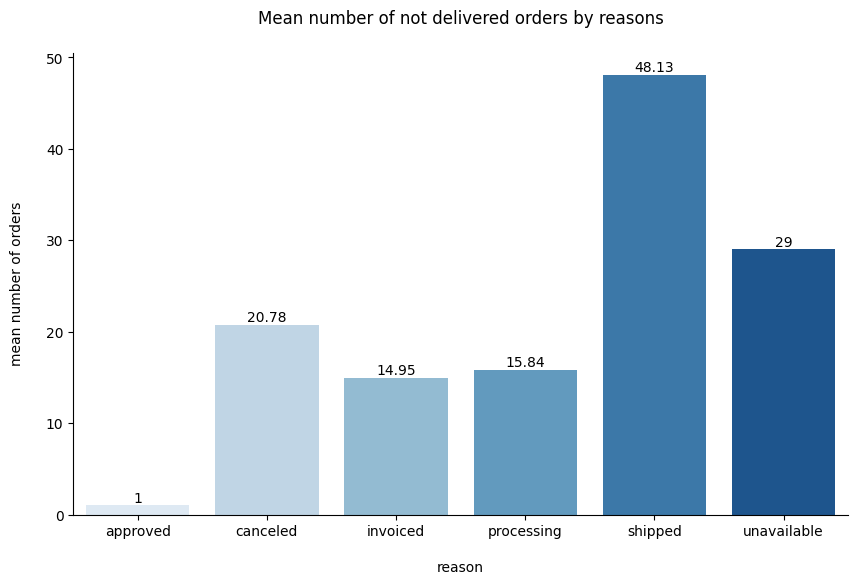

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=not_delivered_by_reason_mean, x='order_status', y='mean_not_delivered_orders', palette='Blues')
ax.set_title('Mean number of not delivered orders by reasons\n')
ax.set_xlabel('\nreason')
ax.set_ylabel('mean number of orders\n')
ax.bar_label(ax.containers[0])
sns.despine()

#### Вывод:
По разным причинам в месяц в среднем не доставляется следующее количесвто заказов:
1. 'shipped' - 48.13
2. 'unavailable' - 29
3. 'canceled' - 20.78
4. 'processing' - 15.85
5. 'invoiced' - 14.95
6. 'approved' - 1

В среднем в месяц отменяется 20.78 заказа и еще 29 имеют статус - "недоступен".

Заказы со статусами 'shipped', 'processing', 'invoiced', approved' находятся в той или иной стадии выполнения и еще могут быть доставлены пользователям.

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [58]:
purchase_items = purchases.merge(items, how='inner', on='order_id')

In [59]:
purchase_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


Днем недели, в который совершается покупка, будем считать день, когда был сформирован заказ (поле 'order_purchase_timestamp').

In [60]:
#добавим колонку с днем недели, когда была совершена покупка
purchase_items['day_name'] = purchase_items.order_purchase_timestamp.dt.day_name()

In [61]:
#посчитаем для каждого товара покупки по дням
purchases_by_day = purchase_items.groupby(['product_id', 'day_name'], as_index=False) \
    .agg({'order_item_id': 'count'}) \
    .rename(columns={'order_item_id': 'total_purchases'})
purchases_by_day.head()

,product_id,day_name,total_purchases
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


In [62]:
#день с наибольшим количеством покупок товара будет иметь ранг 1
purchases_by_day['rank'] = purchases_by_day.groupby('product_id')['total_purchases'] \
                      .rank(method='dense', ascending=False) \
                      .astype(int)
purchases_by_day.head()

,product_id,day_name,total_purchases,rank
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1,1
3,000b8f95fcb9e0096488278317764d19,Friday,1,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1,1


In [63]:
# дни недели, когда каждый товар покупался чаще всего
purchases_by_day_max = purchases_by_day[['product_id', 'day_name']].loc[purchases_by_day['rank'] == 1]
purchases_by_day_max.head()

,product_id,day_name
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000b8f95fcb9e0096488278317764d19,Wednesday


In [64]:
purchases_by_day_max.product_id.value_counts()

product_id
9c31382f02ac001fe1a33a466471d98c    7
51250f90d798d377a1928e8a4e2e9ae1    6
d239ed6ed6dabbcbfd8a3b776e1ca50c    6
1a7d1ce0dddfef9f6f2ed280798fd9bb    6
94950d6ddd0b24c0d15f7f09d61a8148    6
                                   ..
5e9a6c707458f23644bb74a8b9c53222    1
5e98eec44c208da92f2b66345586a229    1
5e98bf1c0b10e3178f1278030034c1fb    1
5e954c4ed342c50436d25d5f50a34919    1
fffe9eeff12fcbd74a2f2b007dde0c58    1
Name: count, Length: 32951, dtype: int64

In [65]:
purchases_by_day.loc[purchases_by_day.product_id == '9c31382f02ac001fe1a33a466471d98c']

,product_id,day_name,total_purchases,rank
37164,9c31382f02ac001fe1a33a466471d98c,Friday,1,1
37165,9c31382f02ac001fe1a33a466471d98c,Monday,1,1
37166,9c31382f02ac001fe1a33a466471d98c,Saturday,1,1
37167,9c31382f02ac001fe1a33a466471d98c,Sunday,1,1
37168,9c31382f02ac001fe1a33a466471d98c,Thursday,1,1
37169,9c31382f02ac001fe1a33a466471d98c,Tuesday,1,1
37170,9c31382f02ac001fe1a33a466471d98c,Wednesday,1,1


In [66]:
order = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [67]:
popular_purc_day = purchases_by_day_max.day_name.value_counts().reindex(order).to_frame().reset_index()

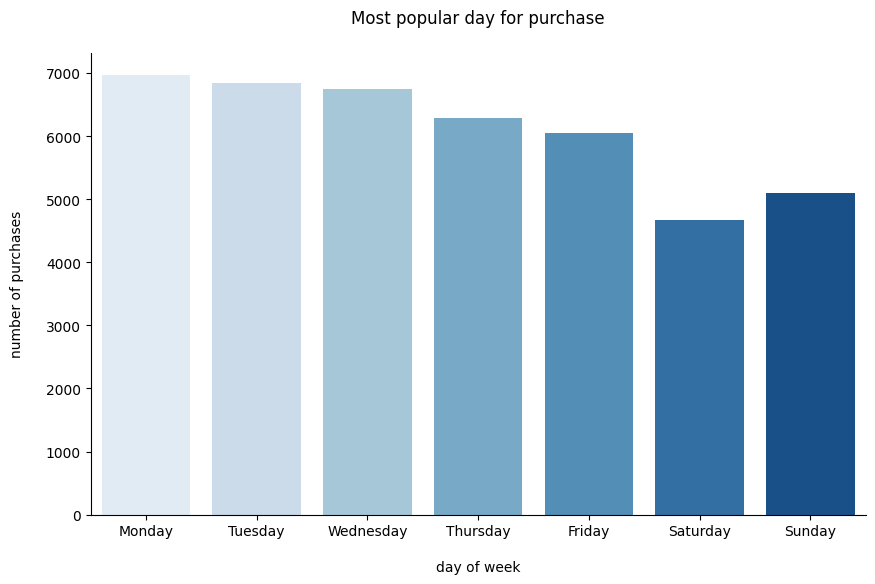

In [68]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=popular_purc_day, x='day_name', y='count', palette='Blues')
ax.set_title('Most popular day for purchase\n')
ax.set_xlabel('\nday of week')
ax.set_ylabel('number of purchases\n')
sns.despine()

#### Вывод:

Для каждого товара был определен день, когда товар покупался чаще всего. Есть товары, которые одинаково часто покупались в разные дни недели. На графике наглядно видно, что частота покупок постепенно уменьшается к концу недели.

### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [69]:
customers_and_purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


1. Посчитаем количесвто покупок для каждого из пользователей по месяцам
2. Определим, сколько в каждом месяце недель
3. Найдем среденее количество покупок в неделю для каждого пользователя по месяцам

In [70]:
#добавим колонку с месяцем покупки
customers_and_purchases['purchase_month'] = customers_and_purchases.order_purchase_timestamp \
    .apply(lambda x: x.strftime('%Y-%m-01'))

In [71]:
customers_and_purchases['purchase_month'] = pd.to_datetime(customers_and_purchases['purchase_month'])

In [72]:
# количесвто покупок пользователей за месяц
purchases_by_month = customers_and_purchases.groupby(['customer_unique_id', 'purchase_month'], as_index=False) \
    .agg(total_by_month=('order_id', 'count'))

In [73]:
#считаем количество дней в месяце
purchases_by_month['days_in_month'] = purchases_by_month.purchase_month.dt.days_in_month

In [74]:
#считаем количество недель в месяце
purchases_by_month['weeks_in_month'] = purchases_by_month.days_in_month / 7

In [75]:
#считаем среднее количесвто покупок в неделю по месяцам для каждого пользователя
purchases_by_month['mean_by_week'] = purchases_by_month.total_by_month / purchases_by_month.weeks_in_month
purchases_by_month.head()

,customer_unique_id,purchase_month,total_by_month,days_in_month,weeks_in_month,mean_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,31,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,31,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,31,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,31,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,30,4.285714,0.233333


In [76]:
mean_by_month_by_week = purchases_by_month[['customer_unique_id', 'purchase_month', 'mean_by_week']]
mean_by_month_by_week.head()

,customer_unique_id,purchase_month,mean_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-01,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,0.233333


In [77]:
mean_by_month_by_week.mean_by_week.describe()

count    97930.000000
mean         0.233404
std          0.029634
min          0.225806
25%          0.225806
50%          0.225806
75%          0.233333
max          1.354839
Name: mean_by_week, dtype: float64

#### Вывод:

Посчитали сколько у каждого из пользователей в среднем покупок в неделю по месяцам.
В среденм пользователи по месяцам совершают 0.233404 покупки в неделю, что примерно соответствует 1 покупке в месяц.

### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [78]:
customers_and_purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02-01


Создадим новый датафрейм содерждащий уникальные идентификаторы пользователей и даты их покупок.

In [79]:
purchases_cohort = customers_and_purchases[['customer_unique_id', 'order_purchase_timestamp']].copy()
purchases_cohort.head()

,customer_unique_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39


In [80]:
purchases_cohort.shape

(99295, 2)

In [81]:
# в столбце с датой и временем покупки оставим только дату
purchases_cohort['order_purchase_timestamp'] = purchases_cohort.order_purchase_timestamp.dt.date

In [82]:
purchases_cohort.rename(columns={'order_purchase_timestamp': 'purchase_date'}, inplace=True)

In [83]:
#найдем месяц, в который была совершена покупка
purchases_cohort['purchase_month'] = purchases_cohort['purchase_date'].to_numpy().astype('datetime64[M]')

In [84]:
# найдем месяц, в который пользователи совершили свою первую покупку
first_customer_purchase = purchases_cohort.groupby('customer_unique_id', as_index=False)['purchase_month'] \
                                                                                        .min()

In [85]:
first_customer_purchase.rename(columns={'purchase_month': 'cohort_month'}, inplace=True)
first_customer_purchase.head()

,customer_unique_id,cohort_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01


In [86]:
purchases_cohort = purchases_cohort.merge(first_customer_purchase, on='customer_unique_id')
purchases_cohort.head()

,customer_unique_id,purchase_date,purchase_month,cohort_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02,2017-10-01,2017-09-01
1,7c396fd4830fd04220f754e42b4e5bff,2017-09-04,2017-09-01,2017-09-01
2,af07308b275d755c9edb36a90c618231,2018-07-24,2018-07-01,2018-07-01
3,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08,2018-08-01,2018-08-01
4,7c142cf63193a1473d2e66489a9ae977,2017-11-18,2017-11-01,2017-11-01


In [87]:
purchases_cohort.duplicated().sum()

946

Получившийся датафрейм содержит дубликаты так, как пользователи совершали несколько покупок в месяц. Удалим дубликаты.

In [88]:
#Удалим дубликаты
purchases_cohort.drop_duplicates(keep='first', inplace=True)

In [89]:
#найдем номер месяца в который были совершены последующие покупки
purchases_cohort['cohort_index'] = ((purchases_cohort.purchase_month - purchases_cohort.cohort_month) / \
                                    np.timedelta64(30, 'D')) \
                                    .round() \
                                    .astype('int')

In [90]:
cohort_table = purchases_cohort.groupby(['cohort_month', 'cohort_index'], as_index=False) \
    .agg({'customer_unique_id': 'count'}) \
    .rename(columns={'customer_unique_id': 'customers_number'}) \
    .sort_values('cohort_month')
cohort_table.head()

,cohort_month,cohort_index,customers_number
0,2016-09-01,0,4
8,2016-10-01,19,2
7,2016-10-01,17,1
6,2016-10-01,15,1
5,2016-10-01,13,1


In [91]:
cohort_table['cohort_month'] = cohort_table['cohort_month'].apply(lambda x: x.strftime('%Y-%m'))

In [92]:
# строим сводную таблицу и считаем retention для каждой когорты
cohort_table_pivot = cohort_table.pivot(index='cohort_month',columns='cohort_index', values='customers_number')
cohort_table_pivot = cohort_table_pivot.divide(cohort_table_pivot.iloc[:,0], axis=0) \
                    .round(4)

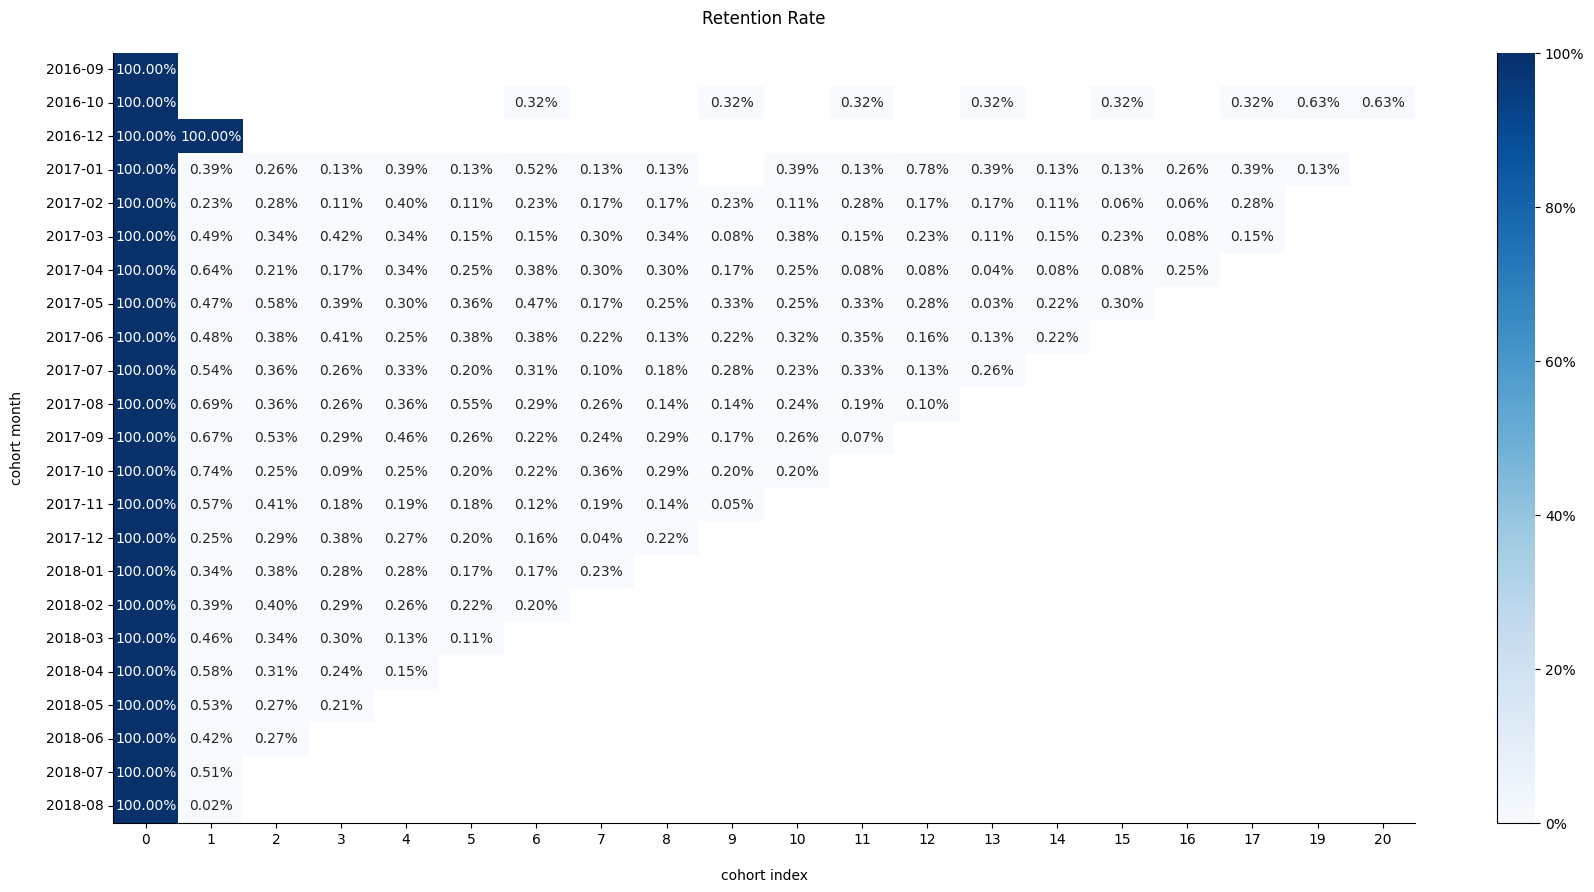

In [93]:
fig, ax = plt.subplots(figsize=(21,10))
fmt = lambda x,pos:'{:.0%}'.format(x)
sns.heatmap(cohort_table_pivot, vmin=0, vmax=1, annot=True,
            cmap="Blues", fmt=".2%", cbar_kws={'format': FuncFormatter(fmt)})
ax.set_title('Retention Rate\n')
ax.set_xlabel('\ncohort index')
ax.set_ylabel('cohort month\n')
sns.despine()

#### Вывод:
Самый высокий Retention Rate за 3 месяц у когорты '2017-03' - 0.42%.

### 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

1. Посчитаем Recency - число дней со дня последней покупки
2. Посчитаем Frequency - количество покупок за период
3. Посчитаем Monetary - сумма потраченная за период
4. Разобьем метрки на равные группы
5. Проранжируем группы
6. Сгруппируем R, F, M оценки для получения RFM
7. Учитывая RFM сделаем сегментацию пользователей
8. Для каждого RFM сегмента найдем границы метрик recency, frequency и monetary

Для RFM сегментации будем использовать данные за последние 12 месяцев. Так как эти данные будут наиболее актуальными.

Для начала возьмем данные об уникальных пользователях и их покупках за посление 12 месяцев.

Для этого объеденим все 3 таблицы 'orders', 'customers' и 'items'. И возьмем информацию о клиентах, датах их покупок и ценах на товары.

In [94]:
purchases_rfm = orders.merge(customers, on='customer_id').merge(items, on='order_id')
purchases_rfm = purchases_rfm[['customer_unique_id', 'order_purchase_timestamp', 'price']].copy()

In [95]:
purchases_rfm.head()

,customer_unique_id,order_purchase_timestamp,price
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,29.99
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,159.90
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,19.90


In [96]:
# оставим только дату покупки без времени
purchases_rfm['order_purchase_timestamp'] = purchases_rfm['order_purchase_timestamp'].dt.date

In [97]:
purchases_rfm.rename(columns={'order_purchase_timestamp': 'purchase_date'}, inplace=True)

In [98]:
purchases_rfm.head()

,customer_unique_id,purchase_date,price
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02,29.99
1,af07308b275d755c9edb36a90c618231,2018-07-24,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08,159.90
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13,19.90


Так как в одном заказе могло быть несколько продуктов, то посчитаем для каждого пользователя суммарный чек.

In [99]:
purchases_rfm = purchases_rfm.groupby(['customer_unique_id', 'purchase_date'], as_index=False)['price'].sum()

In [100]:
purchases_rfm.duplicated().sum()

0

Добавим колонку с днем, который следует за последней покупкой. Чтобы от него считать, как давно была совершена последняя покупка (Recency).

In [101]:
purchases_rfm['current_day'] = purchases_rfm['purchase_date'].max() + timedelta(days=1)

Теперь оставим только данные за последние 12 месяцев.

In [102]:
purchases_rfm = purchases_rfm.loc[purchases_rfm['purchase_date'] >=
                                  purchases_rfm['purchase_date'].max() - timedelta(days=365)]

In [103]:
purchases_rfm['purchase_date'] = pd.to_datetime(purchases_rfm['purchase_date'], format='%Y-%m-%d')
purchases_rfm['current_day'] = pd.to_datetime(purchases_rfm['current_day'], format='%Y-%m-%d')

Для нахождения Recency найдем разницу между текущей датой и датой покупки и возьмем минимальное значение.

In [104]:
purchases_rfm['days_since_last_purchase'] = (purchases_rfm['current_day'] - purchases_rfm['purchase_date']).dt.days

In [105]:
purchases_rfm.head()

,customer_unique_id,purchase_date,price,current_day,days_since_last_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,129.90,2018-09-04,117
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,18.90,2018-09-04,120
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,25.99,2018-09-04,327
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,180.00,2018-09-04,294
5,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05,154.00,2018-09-04,152


Находим Recency, Frequency и Monetary

In [106]:
rfm = purchases_rfm.groupby(['customer_unique_id'], as_index=False) \
    .agg({'days_since_last_purchase': 'min', 'purchase_date': 'count', 'price': 'sum'}) \
    .rename(columns={'days_since_last_purchase': 'recency', 'purchase_date': 'frequency', 'price': 'monetary'})

In [107]:
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,294,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,152,1,154.00


Теперь по каждой метрике Recency, Frequency и Monetary присвоим пользователям оценку в интервале от 1 до 4.

In [108]:
rfm.recency.describe()

count    73374.000000
mean       177.689754
std         98.889346
min          1.000000
25%         94.000000
50%        177.000000
75%        265.000000
max        366.000000
Name: recency, dtype: float64

Text(0, 0.5, 'customers')

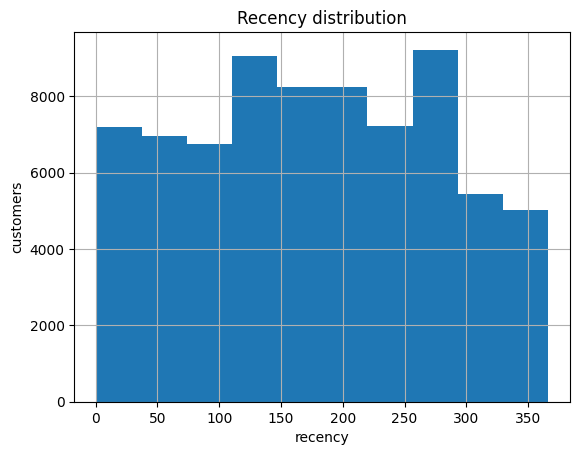

In [109]:
rfm.recency.hist()
plt.title('Recency distribution')
plt.xlabel('recency')
plt.ylabel('customers')

Метрика Recency распределена равномерно, поэтому просто разобьем ее на 4 примерно равные группы.

In [110]:
rfm['r'] = 5 - (pd.qcut(rfm['recency'], q=4, labels=False) + 1)

In [111]:
# границы для метрики 'recency'
rfm.groupby('r')['recency'].agg(['mean', 'count', 'min', 'max'])

,mean,count,min,max
r,,,,
1,307.762062,18177,266,366
2,218.009039,18365,178,265
3,137.342779,18350,95,177
4,49.758738,18482,1,94


Таким образом видно, что мы поделили пользователей примерно на равные группы.

In [112]:
rfm.frequency.value_counts()

frequency
1     72073
2      1216
3        68
4         8
5         4
7         2
6         2
11        1
Name: count, dtype: int64

Text(0, 0.5, 'customers')

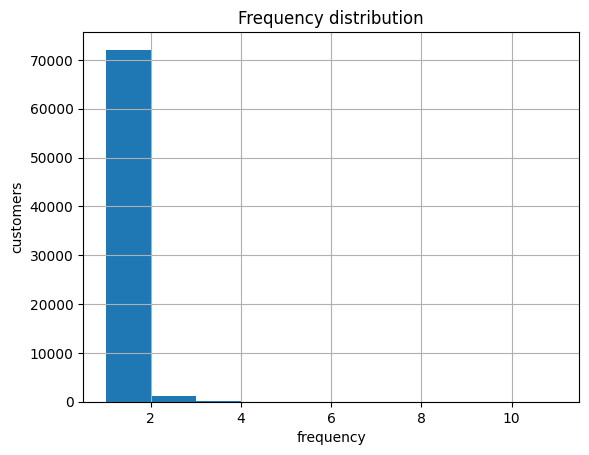

In [113]:
rfm.frequency.hist()
plt.title('Frequency distribution')
plt.xlabel('frequency')
plt.ylabel('customers')

Видно, что подавляющая часть пользователей совершила только 1 покупку. Поэтому по метрике Frequency разобьем их на следующие группы:

- 1 группа: 1 покупка
- 2 группа: 2-3 покупки
- 3 группа: 4-5 покупок
- 4 группа: 6 и более покупок

In [114]:
#функция для получения f скора
def get_f_score(frequency):
    if frequency == 1:
        return 1
    elif frequency in [2, 3]:
        return 2
    elif frequency in [4, 5]:
        return 3
    else:
        return 4

In [115]:
rfm['f'] = rfm['frequency'].apply(get_f_score)

In [116]:
rfm['f'].value_counts()

f
1    72073
2     1284
3       12
4        5
Name: count, dtype: int64

In [117]:
# границы для метрики 'frequency'
rfm.groupby('f')['frequency'].agg(['mean', 'count', 'min', 'max'])

,mean,count,min,max
f,,,,
1,1.000000,72073,1,1
2,2.052960,1284,2,3
3,4.333333,12,4,5
4,7.400000,5,6,11


In [118]:
rfm.monetary.describe()

count    73374.000000
mean       141.497747
std        213.061899
min          0.850000
25%         47.900000
50%         89.900000
75%        153.000000
max      13440.000000
Name: monetary, dtype: float64

Text(0, 0.5, 'customers')

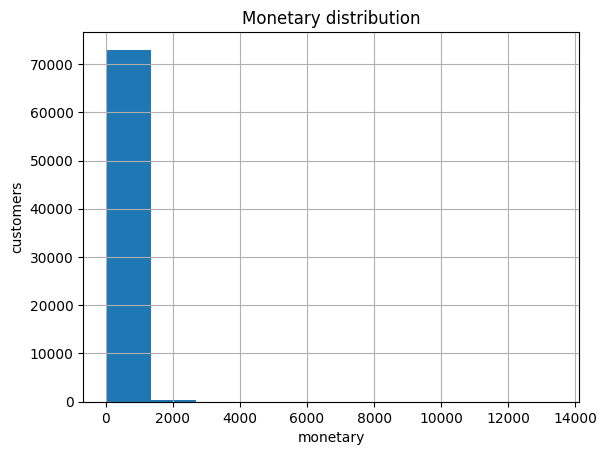

In [119]:
rfm.monetary.hist()
plt.title('Monetary distribution')
plt.xlabel('monetary')
plt.ylabel('customers')

Почти все пользователи совершили покупки на сумму не более 1000.

Text(0, 0.5, 'customers')

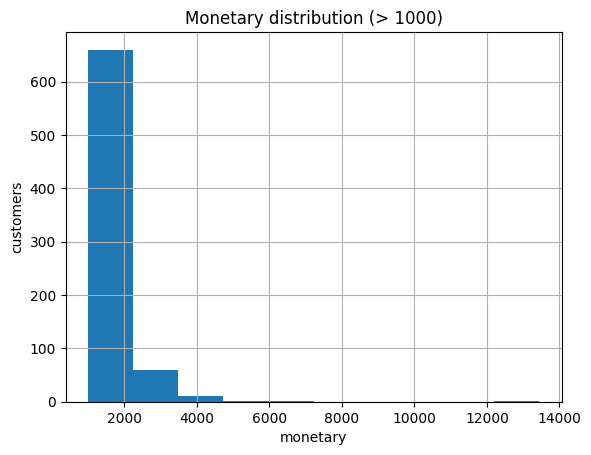

In [120]:
rfm.monetary.loc[(rfm['monetary'] > 1000)].hist()
plt.title('Monetary distribution (> 1000)')
plt.xlabel('monetary')
plt.ylabel('customers')

In [121]:
rfm.monetary.loc[(rfm['monetary'] > 1000)].count() / len(rfm) * 100

1.0003543489519449

In [122]:
rfm.monetary.loc[(rfm['monetary'] > 1000)].sum() / rfm['monetary'].sum() * 100

11.345970157562107

Всего 1% от всех покупателей потратили больше 1000. При этом они принесли 11.35% от всей выручи. Поэтому выделим их в отдельную группу, как тех, кто тратит больше всех.

Далее посмотрим на пользователей, кто потратил до 1000.

Text(0, 0.5, 'customers')

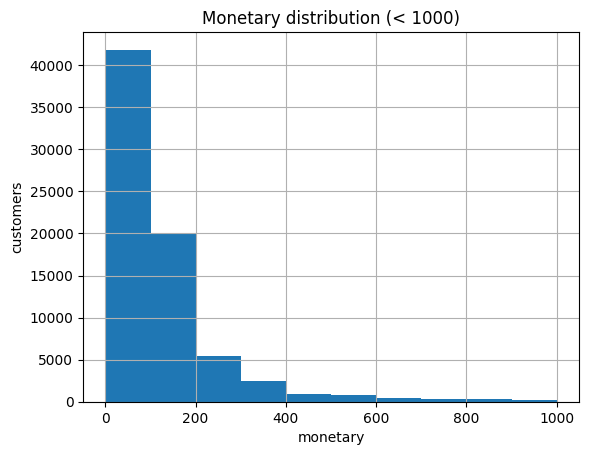

In [123]:
rfm.monetary.loc[(rfm['monetary'] < 1000)].hist()
plt.title('Monetary distribution (< 1000)')
plt.xlabel('monetary')
plt.ylabel('customers')

Остальных пользователей можно разбить на следующие три группы:
- 0 - 150
- 151 - 300
- 301 - 1000

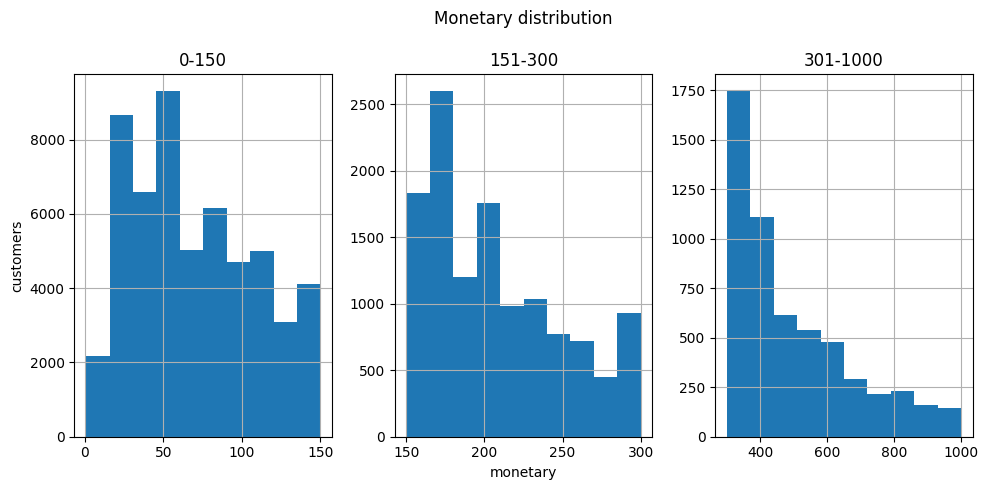

In [124]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))
rfm.monetary.loc[(rfm['monetary'] <= 150)].hist(ax=ax[0])
ax[0].set_title('0-150')
ax[0].set_ylabel('customers')
rfm.monetary.loc[(rfm['monetary'] > 150) & (rfm['monetary'] <= 300)].hist(ax=ax[1])
ax[1].set_xlabel('monetary')
ax[1].set_title('Monetary distribution\n\n151-300')
rfm.monetary.loc[(rfm['monetary'] > 300) & (rfm['monetary'] <= 1000)].hist(ax=ax[2])
ax[2].set_title('301-1000')
plt.tight_layout()

In [125]:
#функция для получения m скора
def get_m_score(monetary):
    if monetary <= 150:
        return 1
    elif 150 < monetary <= 400:
        return 2
    elif 400 < monetary <= 1000:
        return 3
    else:
        return 4

In [126]:
rfm['m'] = rfm['monetary'].apply(get_m_score)

In [127]:
# границы для метрики 'monetary'
rfm.groupby('m')['monetary'].agg(['mean', 'count', 'min', 'max'])

,mean,count,min,max
m,,,,
1,70.876274,54830,0.85,150.0
2,232.718873,14728,150.19,400.0
3,613.451781,3082,400.15,1000.0
4,1604.860531,734,1000.85,13440.0


Теперь можем сегментировать пользователей по rfm скору.

In [128]:
rfm['rfm'] = rfm.r.astype('str') + rfm.f.astype('str') + rfm.m.astype('str')

In [129]:
rfm.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,3,1,1,311
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,3,1,1,311
2,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,1,1,2,112
4,0004bd2a26a76fe21f786e4fbd80607f,152,1,154.00,3,1,2,312


Для каждого RFM сегмента найдем границы метрик recency, frequency и monetary

In [130]:
rfm.groupby('rfm').agg({'recency':['min', 'max'],
                                        'frequency': ['min', 'max'],
                                        'monetary': ['min', 'max']}).sort_index(ascending=False)

recency      frequency     monetary          
        min  max       min max      min       max
rfm                                              
443      15   68         6  11   440.94    664.20
434      75   79         4   5  1535.40   1650.00
433      12   80         4   5   439.40    633.16
424      22   92         2   3  1021.50   4080.00
423       9   93         2   3   401.20    999.90
422       1   94         2   3   150.19    397.80
421       7   93         2   3    22.49    149.99
414       9   94         1   1  1005.55   7160.00
413       6   94         1   1   402.35    999.99
412       6   94         1   1   150.40    399.99
411       6   94         1   1     2.20    150.00
343      95   95         7   7   806.61    806.61
333     153  153         4   4   422.35    422.35
332     152  152         4   4   175.19    175.19
324      95  162         2   3  1004.99   1828.44
323     101  176         2   3   401.64    983.99
322      96  177         2   3   150.90    399.80
321      96  176         2   3    19.80    148.00
314      95  177         1   1  1001.00   4400.00
313      95  177         1   1   403.90   1000.00
312      95  177         1   1   150.88    400.00
311      95  177         1   1     0.85    150.00
244     189  189         6   6  1000.85   1000.85
243     202  202         7   7   809.21    809.21
233     182  259         4   5   486.00    745.80
224     181  261         2   2  1109.80   1663.00
223     178  245         2   3   408.00    965.80
222     178  264         2   3   152.55    399.80
221     178  264         2   3    11.98    149.98
214     179  265         1   1  1005.63   3690.00
213     178  265         1   1   400.15    999.90
212     178  265         1   1   150.90    400.00
211     178  265         1   1     2.99    150.00
132     287  287         4   4   288.00    288.00
124     270  353         2   2  1044.90   2999.98
123     266  350         2   3   404.80    944.60
122     266  364         2   2   159.98    399.56
121     266  361         2   2    25.80    144.90
114     266  366         1   1  1004.99  13440.00
113     266  366         1   1   402.90    999.99
112     266  366         1   1   150.54    400.00
111     266  366         1   1     2.29    150.00

Также найдем общий rfm скор и на его основе добавим название сегментов

In [131]:
rfm['rfm_score'] = rfm.r + rfm.f + rfm.m

In [132]:
def rfm_segments(df):
    if df['rfm_score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['rfm_score'] >= 8) and (df['rfm_score'] < 9)):
        return 'Champions'
    elif ((df['rfm_score'] >= 7) and (df['rfm_score'] < 8)):
        return 'Loyal'
    elif ((df['rfm_score'] >= 6) and (df['rfm_score'] < 7)):
        return 'Potential'
    elif ((df['rfm_score'] >= 5) and (df['rfm_score'] < 6)):
        return 'Promising'
    elif ((df['rfm_score'] >= 4) and (df['rfm_score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'


In [133]:
rfm['segment'] = rfm.apply(rfm_segments, axis=1)

In [134]:
rfm.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm,rfm_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,3,1,1,311,5,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,3,1,1,311,5,Promising
2,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,1,1,1,111,3,Require Activation
3,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,1,1,2,112,4,Needs Attention
4,0004bd2a26a76fe21f786e4fbd80607f,152,1,154.00,3,1,2,312,6,Potential


In [135]:
pd.set_option('display.max_colwidth', None)

In [136]:
# разбиение на сегменты по rfm скору
rfm.groupby('segment', as_index=False)['rfm'].unique()

,segment,rfm
0,Can't Loose Them,"[414, 424, 324, 423, 243, 333, 433, 434, 244, 443, 343]"
1,Champions,"[413, 314, 422, 323, 224, 233, 332]"
2,Loyal,"[412, 313, 421, 322, 214, 223, 124]"
3,Needs Attention,"[112, 211, 121]"
4,Potential,"[312, 411, 213, 321, 114, 222, 123, 132]"
5,Promising,"[311, 212, 113, 122, 221]"
6,Require Activation,[111]


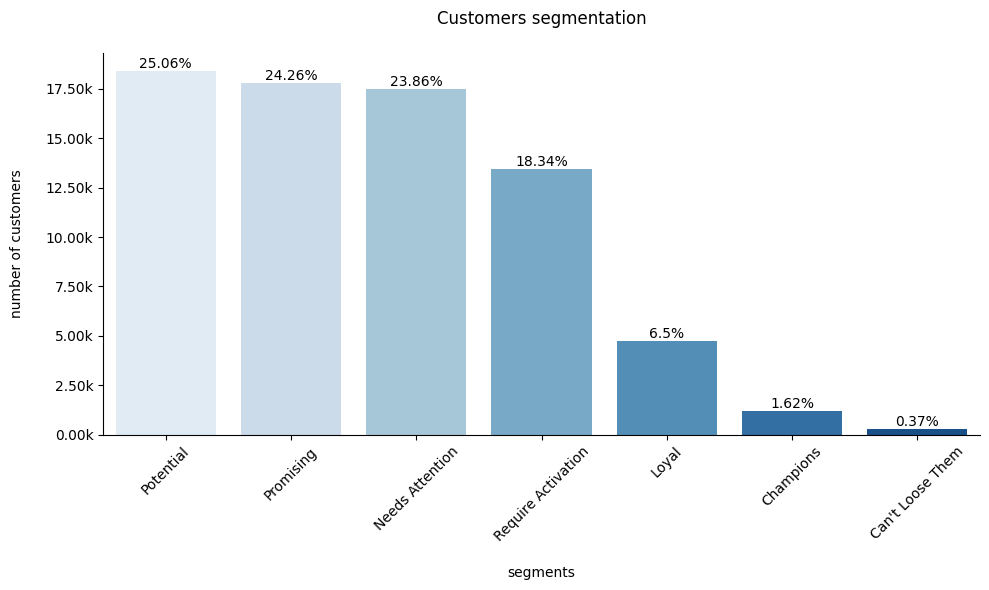

In [137]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=rfm, x='segment', order=rfm.segment.value_counts().index, palette='Blues')
ax.bar_label(ax.containers[0], labels=rfm.segment.value_counts(normalize=True).mul(100).round(2).astype('str') + '%')
ax.set_title('Customers segmentation\n')
ax.set_xlabel('\nsegments')
ax.set_ylabel('number of customers\n')
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000) + 'k'))
plt.tight_layout()
sns.despine()

Сегменты:
- **Require Activation** - Скорее всего, эти клиенты уже ушли от нас, и потребуют новой стратегии для их привлечения. Можно автоматическую цепочку реактивации.


- **Needs Attetion** - Эти клиенты сделали у нас несколько покупок, а потом перестали покупать. Их можно попытаться вернуть и обязательно получить обратную связь, почему они от нас ушли. Можно отправить реактивационную рассылку с опросом.

- **Promising** - Этих клиентов обязательно нужно попытаться вернуть. Отправляем им реактивационные письма, запрашиваем обратную связь, предлагаем бонусы, программы лояльности.

- **Potential** - Предложить членство / программу лояльности. Стараться держать их вовлеченными. Предлагать персональные рекомендации.

- **Loyal** - Можно попытаться увеличить сумму чека допродажей. Отправить им рассылки с сопутствующими товарами.

- **Champions** - Можно как то поощрить. Предложить новые продукты. Могут поспособствовать продвижению бренда. Наиболее вероятно приведут новых клиентов.

- **Can't Loose Them** - Не в коем случае нельзя терять этих клиентов. Можно отправить им особые предложения, например, участие в программе лояльности — приглашение в клуб любимых клиентов.

### Выводы:

Для решения поставленных задач было принято решение считать покупкой все заказы со статусом 'delivered', а также все заказы, в которых есть подтверждение оплаты заказа (наличие даты в колонке 'order_approved_at'), кроме заказов со статусом 'created' (не имеют подтверждения оплаты заказа) и заказов со статусом 'canceled', в которых отсутствует подтверждение оплаты.

Всего внаших данных содержится информация об 96096 уникальных пользователях, которые суммарно совершили 99295 покупок.

Было опредено,что 93061 пользователь совершил только одну покупку.

В месяц в среднем по разным причинам не доставляется следующее количесвто заказов:
1. 'shipped' - 48.13
2. 'unavailable' - 29
3. 'canceled' - 20.78
4. 'processing' - 15.85
5. 'invoiced' - 14.95
6. 'approved' - 1

Для каждого товара был определен день, когда товар покупался чаще всего. Есть товары, которые одинаково часто покупались в разные дни недели.

В среденм пользователи по месяцам совершают 0.233404 покупки в неделю, что примерно соответствует 1 покупке в месяц.

Был проведен когортный анализ пользоваетелей. Самый высокий Retention Rate за 3 месяц у когорты '2017-03' - 0.42%.

Для качественной оценки аудитории была построена RFM-сегментация пользователей.

Треть пользователей находится в оттоковом состоянии. Можно попытаться их вернуть, не тратя при этом много средств. Почти половину пользователей составляют либо новички, либо те кто совершил несколько покупок, но при этом тратит не так много и часто, нужно попытаться их перевести в более лояльный сегмент. Чуть больше 8% составляют наши лучшие покупатели, которые тратят часто и много. Необходимо работать над их удержанием.